# Исследование рынка недвижимости

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Навигация

1. [Открытие файла с данными и изучение общей информации](#start)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#discover)
4. [Общий вывод. Рекомендации.](#Conclusion)

### Шаг 1. <a id="start"></a> Открытие файла с данными и изучение общей информации

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None
ad = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') # ad сокращенно от apartment data ('данные квартир')
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Для изучения был представлен файл с данными, расположенный по адресу - /datasets/real_estate_data.csv
В ходе применения к нему метода .info() было обнаружено, что таблица имеет 23699 строк, 22 столбца.
Представленные в наборе данных столбцы несут следущую информацию:

- total_images — число фотографий квартиры в объявлении
- last_price — цена на момент снятия с публикации
- airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
- balcony — число балконов
- ceiling_height — высота потолков (м)
- cityCenters_nearest — расстояние до центра города (м)
- days_exposition — сколько дней было размещено объявление (от публикации до снятия)
- first_day_exposition — дата публикации
- floor — этаж
- floors_total — всего этажей в доме
- is_apartment — апартаменты (булев тип)
- kitchen_area — площадь кухни в квадратных метрах (м²)
- living_area — жилая площадь в квадратных метрах(м²)
- locality_name — название населённого пункта
- open_plan — свободная планировка (булев тип)
- parks_around3000 — число парков в радиусе 3 км
- parks_nearest — расстояние до ближайшего парка (м)
- ponds_around3000 — число водоёмов в радиусе 3 км
- ponds_nearest — расстояние до ближайшего водоёма (м)
- rooms — число комнат
- studio — квартира-студия (булев тип)
- total_area — площадь квартиры в квадратных метрах (м²)

Перед началом анализа данных для определения рыночной стоимости объектов недвижимости, необходимо подготовить данные:
1. Проанализировать и устранить пропуски
2. Проверить наличие дубликатов
3. Преобразовать данные к неоходимому типу.

### Шаг 2. <a id="preprocessing"></a> Предобработка данных

In [29]:
# заполним пустые значения по столбцам, где это возможно
ad['balcony'] = ad['balcony'].fillna(0)
ad['locality_name'] = ad['locality_name'].fillna('')

# проверим данные на наличие полных дубликатов
ad.duplicated().sum() # полных дубликатов нет
ad['locality_name'] = ad['locality_name'].str.lower() # попробуем привести наименования населенных пунктов к одному регистру
ad.duplicated().sum() # повторно проверяем на число дубликатов. Их также нет

# поскольку значения в столбце is_apartment не имеют значительного интереса для исследования, то можно такой столбец удалить
ad.drop('is_apartment', axis=1, inplace=True)
ad.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,False,25.0,0.0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,False,False,11.0,2.0,посёлок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,False,False,8.3,0.0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,False,False,NaN,0.0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,False,False,41.0,0.0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


### Вывод 

Достоинство пропусков NaN заключается в том, что с ними можно проводить математические операции, поэтому:

1. floors_total - пропущенные значения оставляем пустыми, поскольку такие данные не получить из иных параметров.
2. ceiling_height - оставляем как есть, высота потолков не зависит от этажности дома (проверено), либо иных параметров, поэтому ее можно оставить так как есть (с пустыми значениями).
3. living_area - также оставляем с пустыми данными, поскольку такую площадь нельзя получить исходя из имеющейся информации, хотя и напрашивается вариант вычесть из общей площади площадь кухни, но такой подход не будет достоверным, поскольку не учитывает иные нежилые пространства (например, санузел).
4. kitchen_area - оставляем пустые значения (см.п.3)
5. значения в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - также оставляем пустыми, хотя и можно было предпринять попытку замены таких значений на медиану расстояния для соответствующего населенного пункта, одна с учетом, что число таких населенных пунктов велико и они имеют разные площади, то велика вероятность погрешности в расчетах.
6. days_exposition - значение остается пустым, поскольку хотя мы и имеем парамент - дата публикации, но неизвестна дата снятия публикации, следовательно, заполнить такой столбец данными не представляется возможным.

Пустые значения по столбцам floors_total, ceiling_height, living_area, kitchen_area скорее всего связаны с тем, что собственники таких объектов недвижимости не знают (не вспомнили) таких параметров своих квартир, поэтому и пропустили их. 
Отсутствие значений в столбцах airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest - скорее всего связано с тем, что такие сведения получены автоматически на основе картографических данных, следовательно, мог произойти сбой в системе при рассчете таких параметров, либо система не точно оценило обстановку вокруг дома и близлежащие объекты.
Отсутствие значений в параметре days_exposition связано с отсутствием в данных параметра даты снятия объявления с сайта, поэтому и могли возникнуть пустые значения.

Поскольку пустые значения встречались и в иных столбцах, то по ним были проведены заполнения значений:
1. balcony - значения по такому столбцу были заменены на 0, поскольку если человек не указал число балконов — скорее всего, их нет.
2. locality_name - значения заменены на пустые строки.

Столбец is_apartment удален, поскольку, хотя апартаменты и являюстя самостоятельным объектом недвижимости, по своей сути являюстя жилым помещением и для исследования не оказывают значительного влияния.

In [13]:
# переведем преобразования типов данных

ad['last_price'] = ad['last_price'].astype('int')
ad['floors_total'] = ad['floors_total'].astype(pd.Int64Dtype())
ad['balcony'] = ad['balcony'].astype('int')
ad['parks_around3000'] = ad['parks_around3000'].astype(pd.Int64Dtype())
ad['ponds_around3000'] = ad['ponds_around3000'].astype(pd.Int64Dtype())

ad['days_exposition'] = ad['days_exposition'].round() # перед переводом округлим значения
ad['days_exposition'] = ad['days_exposition'].astype(pd.Int64Dtype())

Для дальнейшего использования преобразовали типы данных по столбцам last_price, floors_total, balcony, parks_around3000, ponds_around3000, days_exposition преобразовали из типа данных float64 в int64 (Int64), поскольку значения в таком столбце могут быть только целочисленными. Значения в иных столбцах либо уже имеют необходимый тип, либо сохраняют имеющийся, поскольку такие параметры могут иметь дробное значение (например, расстояние).

#### Создадим необходимые столбцы

In [14]:
# создадим столбец price_per_m, в котором будут хратиться данные о стоиости одного квадратного метра 
# недвижимости и округлим значения до сотых (2 знака после запятой)
ad['price_per_m'] = (ad['last_price'] / ad['total_area']).round(2)  


# создадим отдельные столбцы с днем недели, месяцем и годом публикации объявления
ad['first_day_exposition'] = pd.to_datetime(ad['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S') # превращаем данные в понятные для анализа и обработки даты
ad['weekday'] = ad['first_day_exposition'].dt.weekday # создаем столбец с номером дня недели, где 0- понедельник, а 6-воскресенье.
ad['month'] = pd.DatetimeIndex(ad['first_day_exposition']).month # создаем столбец с номером месяца, где 1-январь, а 12-декабрь
ad['year'] = pd.DatetimeIndex(ad['first_day_exposition']).year # создаем столбец для года

# создадим функцию для определения этажа
def what_the_floor (row):
    personal_floor = row['floor']
    floors_total = row['floors_total']
    if personal_floor == 1:
        return 1                           # первый этаж
    if personal_floor == floors_total:
        return 3                           # последний этаж
    return 2                               # этажи со второго по предпоследний
ad['name_floor'] = ad.apply(what_the_floor, axis=1)

In [15]:
# создадим столбец с соотношением жилой площади к общей и округлим до 3 знаков после запятой 
# (все, что за пределами тысячных не способно оказать значительное влияние на исследование)
ad['living/total'] = (ad['living_area'] / ad['total_area']).round(3)

In [16]:
# создадим столбец с соотношением площади кухни к общей и округлим до 3 знаков после запятой 
ad['kitchen/total'] = (ad['kitchen_area'] / ad['total_area']).round(3)

### Вывод 
Для дальнейшей работы создали следующие столбцы:
1. price_per_m, в котором будут храниться данные о стоимости одного квадратного метра недвижимости и округлим значения до сотых (2 знака после запятой)
2. отдельные столбцы с днем недели (weekday), месяцем (month) и годом (year) публикации объявления
3. name_floor - в котором через функцию и метод .apply() изучили все этажи и в новом столбце единицу присвоили квартирам, расположенным на первом этаже, 2 - со второго по предпоследний, 3 - для последнего этажа в здании.
4. living/total - столбец с соотношением жилой площади к общей и округлим до 3 знаков после запятой
5. kitchen/total - столбец с соотношением площади кухни к общей и округлим до 3 знаков после запятой 


### Шаг 3. <a id="discover"></a> Исследовательский анализ данных

### Анализ параметров: площадь, цена, число комнат, высота потолков

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1d1700410>]],
      dtype=object)

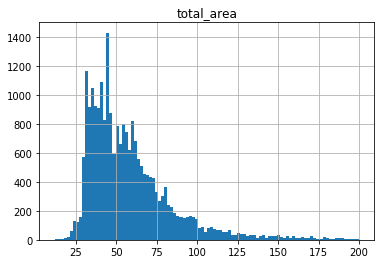

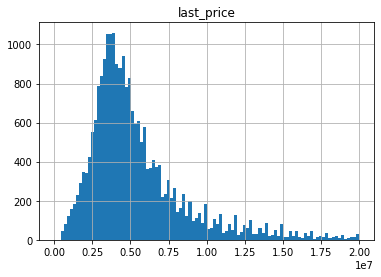

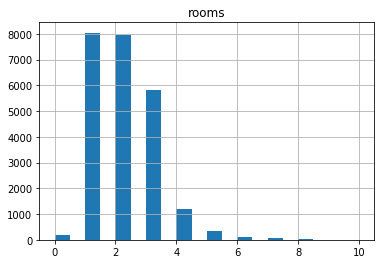

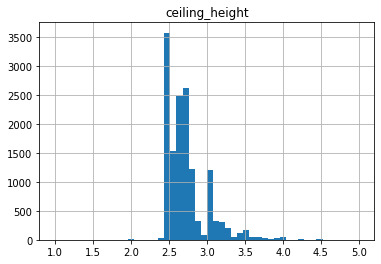

In [17]:
# Теперь построми по ним гистограммы

ad.hist('total_area', bins=100, range=(12, 200)) 

ad.hist('last_price', bins=100, range=(12190,  20000000))

ad.hist('rooms', bins=20, range=(0, 10))

ad.hist('ceiling_height', bins=50, range=(1, 5))

### Вывод 
Проанализировав параметры: площадь, цена, число комнат, высота потолков, - были обнаружены значительные выбросы, которые нужно будет обнаружить и устранить в будущем.






### Проверка времени продажи квартиры. 

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

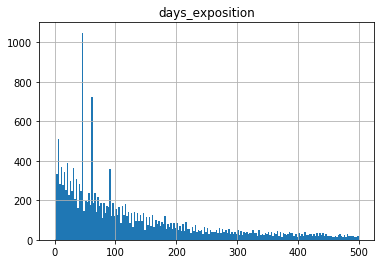

In [18]:
ad.hist('days_exposition', bins=200, range=(0, 500))
ad['days_exposition'].describe()

# ad.boxplot('days_exposition') 
# построим также график боксплот ("ящик с усами"), чтобы определить размер нормальных значений, 
# все, что за его пределами - это выбросы.

### Вывод 
Применив метод .describe() к столбцу days_exposition датафрейма ad получили информацию, что:
- среднее время продажи составляет 180 дней
- медиана - 95 дней

Медина меньше среднего арифметического почти в два раза. Это явно говорит о том, что в распределении длинный хвост высоких значений (или несколько очень больших значений), влияющих на среднее, но не на медиану.

Построив график боксплот ("ящик с усами") определили размах нормальных значений, чтобы определить границы выбросов.
Таким образом, нормальные значения находятся в границах 1-500. В будущем нужно будет ограничить данные в этом масштабе.
Следовательно, с учетом, что первый квартиль расположен на границе 45 дней, то можно предположить, что быстрые продажи - это те, который осуществляются быстрее чем за полтора месяца.
Слишком долгие продажи - более 500 дней (это почти полтора года).
При этом график на гистограмме в 45 и 60 днях имеет значительные выбросы. Дальше нужно будет такие данные исключить из общего исследования.

### Исключение редких и выбивающихся значений

In [19]:
# Изучим следующие параметры: площадь, цена, число комнат, высота потолков. 

ad['total_area'].describe() 
# Для определения нормальных значений посчитаем межквартильный размах и найдем "усы" для наших данных
area_iqr = (69.9 - 40) * 1.5
area_iqr # 44.85
# следовательно, нормальные значения находятся на расстоянии 12-114,75 кв.м.

ad['last_price'].describe() 
price_iqr = (6800000 - 3400000)*1.5
price_iqr 
# нормальное значение: 12190 - 11900000

ad['rooms'].describe() 
# нормальное значение от 1 до 6.

ad['ceiling_height'].describe() 
height_iqr = (2.8-2.52)*1.5
height_iqr 
# нормальное значение от 2,1 до 3,22.

ad['days_exposition'].describe()
exposition = (232-45) * 1.5
exposition
# нормальное значение от 1 до 512

280.5

In [20]:
# с учетом ранее полученных результатов создадим новую таблицу good_stat, в которой сделаем срез без учета выбросов

good_stat = ad.query('12 < total_area < 114.75 & \
                    12190 < last_price < 11900000 & \
                    1 < rooms < 6 & \
                    2.1 < ceiling_height < 3.22 & \
                    1 < days_exposition < 512')
good_stat.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_m,weekday,month,year,name_floor,living/total,kitchen/total
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121,100000.00,1,6,2018,2,0.320,0.410
9,18,5400000,61.0,2017-02-26,3,2.50,9,43.6,7,False,False,6.5,2,санкт-петербург,50898.0,15008.0,0,NaN,0,NaN,289,88524.59,6,2,2017,2,0.715,0.107
13,20,3550000,42.8,2017-07-01,2,2.56,5,27.0,5,False,False,5.2,1,петергоф,37868.0,33058.0,1,294.0,3,298.0,366,82943.93,5,7,2017,3,0.631,0.121
16,11,6700000,82.0,2017-11-23,3,3.05,5,55.6,1,False,False,9.0,0,санкт-петербург,22108.0,10698.0,3,420.0,0,NaN,397,81707.32,3,11,2017,1,0.678,0.110
20,12,6120000,80.0,2017-09-28,3,2.70,27,48.0,11,False,False,12.0,2,посёлок парголово,53134.0,19311.0,0,NaN,0,NaN,74,76500.00,3,9,2017,2,0.600,0.150


## Вывод 
Применив метод .describe() к столбцам total_area, last_price, rooms, ceiling_height, days_exposition определили квартили и нашли межквартильный размах для каждого из столбцов.
Используя знания о "ящике с усами" нашли нормальные значения для каждого из параметров, исключив нули*.
На основе таких данных, создали переменную good_stat, в которую сохранили срез данных, удовлетворяжщих условиям.
Из исходных 23699 исследований осталось 5988. Ушло почти 75% значений имеющих выбросы. Это много, но зато такая таблица лишена выбросов.

*«Усы» простираются влево и вправо от границ ящика на расстояние, равное 1,5 межквартильным размахам (IQR). В размах «усов» попадают нормальные значения, а за пределами находятся выбросы.

### Определение зависимости цены от разных параметров

0.006310341271777717

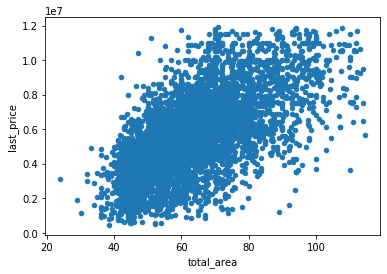

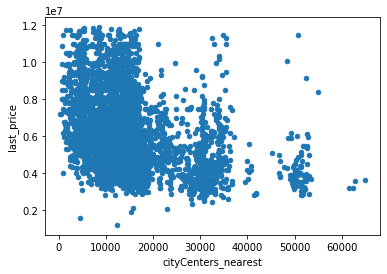

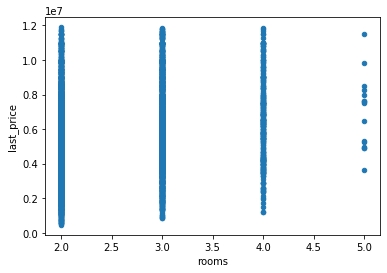

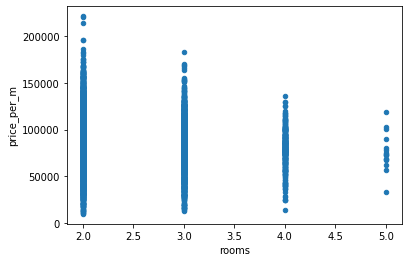

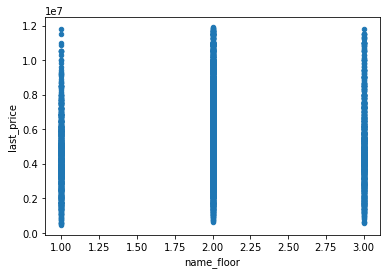

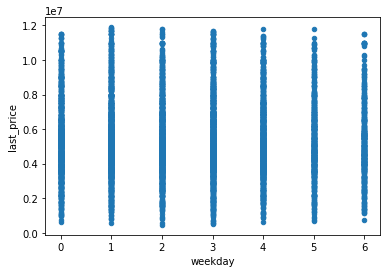

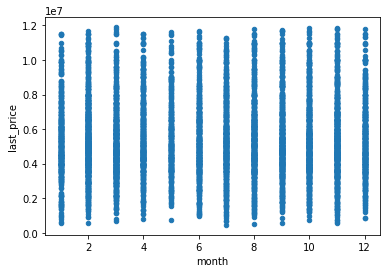

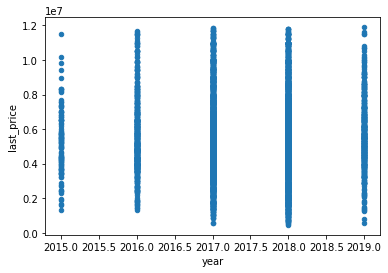

In [21]:
good_stat.plot(x='total_area', y='last_price', kind='scatter')
good_stat['total_area'].corr(ad['last_price']) 
# положительная зависимость присутсвутет, с ростом площади растет и цена на такую недвижимость

good_stat.plot(x='cityCenters_nearest', y='last_price', kind='scatter')
good_stat['cityCenters_nearest'].corr(ad['last_price'])
# зависимость отрицательная, чем дальше от центра - тем ниже стоимость жилья.

good_stat.plot(x='rooms', y='last_price', kind='scatter')
good_stat['rooms'].corr(ad['last_price'])
# зависимость очень слабая, но видно, что при увеличении количества комнат цена постепенно растет
# а может есть более очевидная зависимость между кол-вом комнат и ценой за квадратный метр?


good_stat.plot(x='rooms', y='price_per_m', kind='scatter')
good_stat['rooms'].corr(ad['price_per_m'])
# действительно, чем больше комнат, тем ниже стоимость одного квадртаного метра

good_stat.plot(x='name_floor', y='last_price', kind='scatter')
good_stat['name_floor'].corr(ad['last_price'])
# зависимости почти нет, но максимальная цена на первом этаже ниже, чем на этажах выше.

# проведем проверку зависимости цены от даты размещения объявления
good_stat.plot(x='weekday', y='last_price', kind='scatter')
good_stat['weekday'].corr(ad['last_price'])

good_stat.plot(x='month', y='last_price', kind='scatter')
good_stat['month'].corr(ad['last_price'])

good_stat.plot(x='year', y='last_price', kind='scatter')
good_stat['year'].corr(ad['last_price'])
# с учетом получивышейся информации можно сделать вывод, что дата размещения объявления на цену влияния не оказывает.

,cityCenters_nearest,month,name_floor,rooms,total_area,weekday,year
cityCenters_nearest,1.000000,0.000782,-0.121912,-0.357051,-0.353930,-0.015293,0.092319
month,0.000782,1.000000,-0.006176,0.006379,0.013112,0.041951,-0.265169
name_floor,-0.121912,-0.006176,1.000000,0.101615,0.152529,0.031105,-0.024992
rooms,-0.357051,0.006379,0.101615,1.000000,0.775972,-0.016098,-0.086801
total_area,-0.353930,0.013112,0.152529,0.775972,1.000000,0.013618,-0.111750
weekday,-0.015293,0.041951,0.031105,-0.016098,0.013618,1.000000,-0.030504
year,0.092319,-0.265169,-0.024992,-0.086801,-0.111750,-0.030504,1.000000


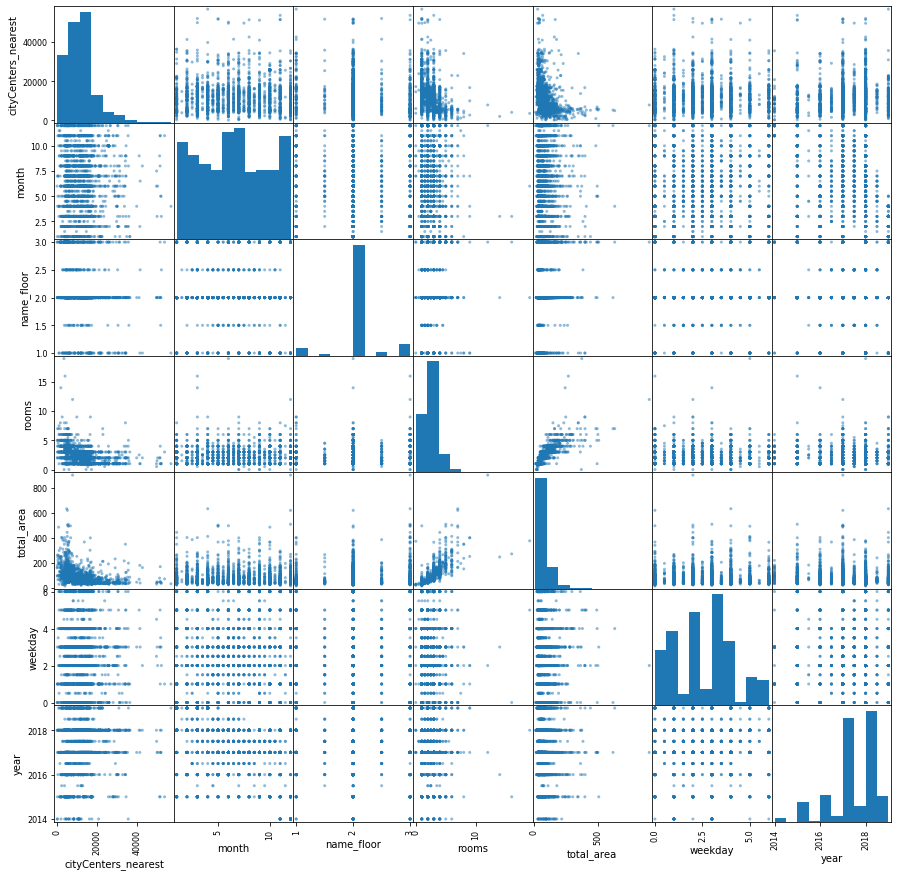

In [22]:
# Матрица корреляции и рассеивания

total = ad.pivot_table(index='last_price', values=['total_area', 'cityCenters_nearest', 'rooms', 'name_floor', 'weekday', 'month', 'year'], aggfunc='median')
pd.plotting.scatter_matrix(total, figsize=(15, 15))
total.corr()

### Вывод 
Построив гистограммы для столбцов, обнаружено:
1. total_area - положительная зависимость присутсвутет, с ростом площади растет и цена на такую недвижимость и количество комнат;
2. cityCenters_nearest - зависимость отрицательная, чем дальше от центра - тем ниже стоимость жилья, меньше площадь и кол-во комнат;
3. rooms - зависимость очень слабая, но видно, что при увеличении количества комнат цена постепенно растет, а может есть более очевидная зависимость между кол-вом комнат и ценой за квадратный метр?
Составив гистограмму зависимости rooms от параметра столбца price_per_m действительно обнаружено, что чем больше комнат, тем ниже стоимость одного квадратного метра.
4. name_floor - зависимости почти нет, но максимальная цена на первом этаже ниже, чем на этажах выше;
5. weekday, month, year - с учетом получившейся информации можно сделать вывод, что дата размещения объявления на цену влияния не оказывает.

### 10 самых активных населенных пунктов

In [23]:
cities = good_stat.pivot_table(index='locality_name', values='price_per_m', aggfunc=['count', 'mean'])
cities.columns = ['count', 'mean']
top_ten = cities.sort_values('count', ascending=False).head(10)
last_ten = cities.sort_values('count', ascending=False).tail(10)

top_ten # 10 населенных пунктов с самым большим числом объявлений и средняя стоимость одного квадратного метра в них
#last_ten # 10 населенных пунктов с самым низким числом объявлений и средняя стоимость одного квадратного метра в них

,count,mean
locality_name,,
санкт-петербург,4081,99406.138358
всеволожск,129,64448.573953
колпино,115,70393.235826
посёлок шушары,110,73395.820818
пушкин,83,94418.405181
гатчина,76,67385.832763
посёлок мурино,63,78985.991587
петергоф,61,81593.224918
сестрорецк,57,96873.366316


### Вывод 
Составив сводную таблицу для датафрейма good_stat получили информацию о 10 городах с бо'льшим количество объявлений и 10 с меньшим. Для них подсчитали количество таких объявлений и среднюю стоимость одного квадратного метра для них.
Больше всего объявлений по Санкт-Петербургу, что очевидно с учетом его размеров.


### Изучение рынка Санкт-Петербурга

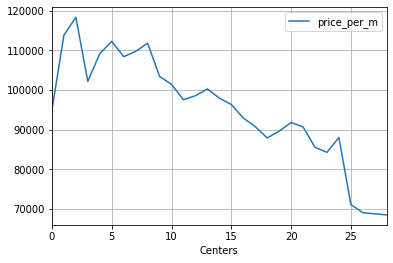

In [24]:
good_stat['locality_name'].unique()
spb = good_stat.query('locality_name == "санкт-петербург"')
spb ['Centers'] = (spb['cityCenters_nearest'] / 1000).round(0)
spb['Centers'] = spb['Centers'].astype(pd.Int64Dtype())

spb.pivot_table(index='Centers', values='price_per_m', aggfunc='mean').plot(grid=True)

### Вывод 
Сделав срез по объявлениям из Санкт-Петербурга, был добавлен новый столбец Centers, в котором сохранены значения расстояния до центра в километрах, округленных до целого значения.

По таким значениям был построен график зависимости стоимости жилья от расположения от центра города, исходя из которого видно, что он делает скачок с 0 до 3,5 км, а потом, начиная с 8 километров, постепенно идет вниз (стоимсоть снижается).

### Анализ недвижимости центра Санкт-Петербурга

0.20745028128085627

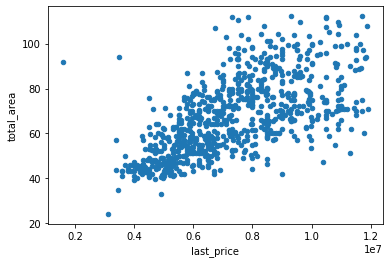

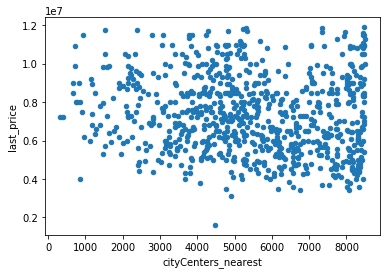

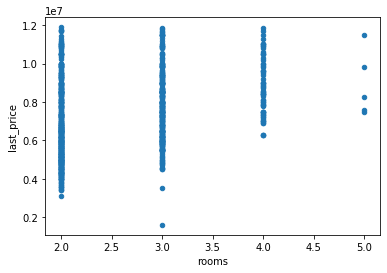

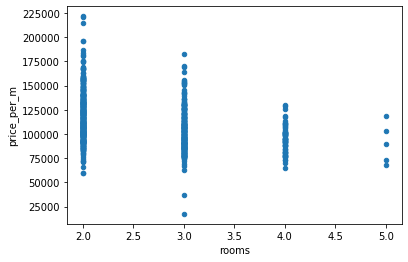

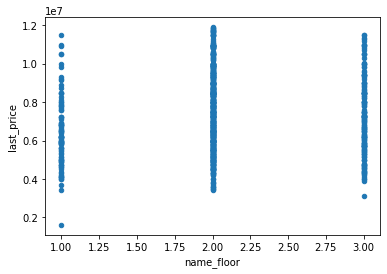

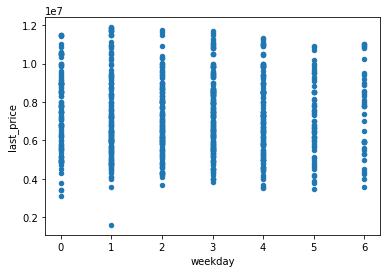

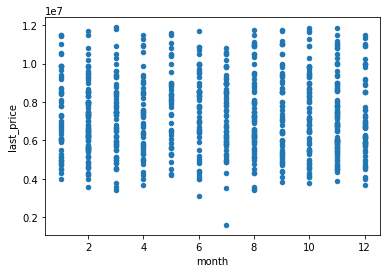

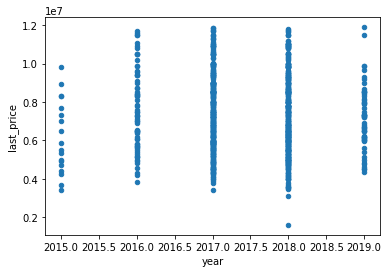

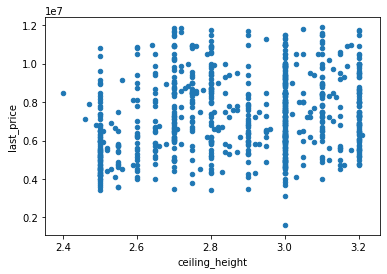

In [25]:
spb_center = spb.query('0 <= Centers <= 8')

spb_center.plot(x='last_price', y='total_area', kind='scatter')
spb_center['total_area'].corr(ad['last_price']) 
# зависимость положительная и прямая - с ростом площади растет и стоимость

spb_center.plot(x='cityCenters_nearest', y='last_price', kind='scatter')
spb_center['cityCenters_nearest'].corr(ad['last_price'])
# в центре города прослеживается слабая зависимость цены от расстояния до центра, 
# но видно, что чем дальше - тем ниже цена, хотя и незначительно.

spb_center.plot(x='rooms', y='last_price', kind='scatter')
spb_center['rooms'].corr(ad['last_price'])
# все очевидно - чем больше комнат, тем больше и цена.

spb_center.plot(x='rooms', y='price_per_m', kind='scatter')
spb_center['rooms'].corr(ad['price_per_m'])
# при этом цена за квадратный метр также снижмает с увеличением числа комнат, 
# как и вцелом по Санкт-Петербургу и Ленинградской области

spb_center.plot(x='name_floor', y='last_price', kind='scatter')
spb_center['name_floor'].corr(ad['last_price'])
# шансов продать квартиры подороже больше не на первом этаже.

# проведем проверку зависимости цены от даты размещения объявления
spb_center.plot(x='weekday', y='last_price', kind='scatter')
spb_center['weekday'].corr(ad['last_price'])
# со вторника по четверг больше объявлений с высокой ценой

spb_center.plot(x='month', y='last_price', kind='scatter')
spb_center['month'].corr(ad['last_price'])
# в течение года зависимость месяца публикации от цены не столь велики (кроме июля)

spb_center.plot(x='year', y='last_price', kind='scatter')
spb_center['year'].corr(ad['last_price'])

spb_center.plot(x='ceiling_height', y='last_price', kind='scatter')
spb_center['ceiling_height'].corr(ad['last_price'])
# зависимость незначительна. Увеличение высота потолка не оказывает сильного влияния на цену недижимости

,Centers,ceiling_height,rooms,total_area
Centers,1.000000,-0.210596,-0.108746,-0.119567
ceiling_height,-0.210596,1.000000,0.113514,0.252718
rooms,-0.108746,0.113514,1.000000,0.681742
total_area,-0.119567,0.252718,0.681742,1.000000


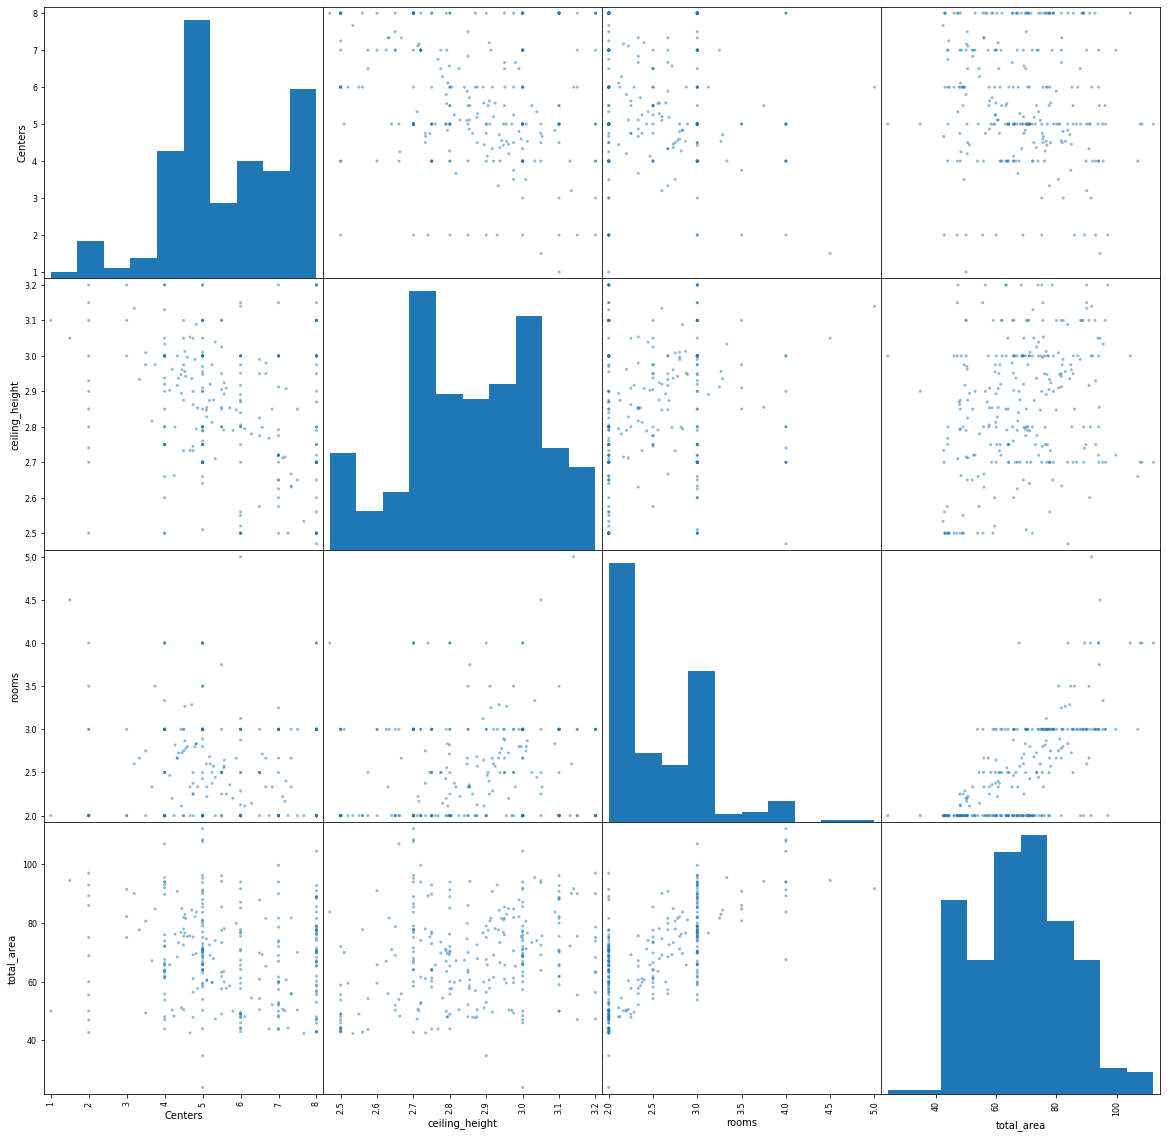

In [26]:
# проверим также и на матрице рассеивания

spb_final = spb_center.pivot_table(index='last_price', values=['total_area', 'Centers', 'rooms', 'ceiling_height'])
pd.plotting.scatter_matrix(spb_final, figsize=(20, 20))
spb_final.corr()
# исходя из данных матрицы корреляции видно, что сильная зависимость количества комнат от площади, остальные значения
# близки к равном нулю (по Пирсону).

### Вывод
Построив гистограммы для квартир, расположенных в центральной зоне Санкт-Петербурга обнаружено:
1. total_area - зависимость положительная и прямая - с ростом площади растет и стоимость;
2. cityCenters_nearest - в центре города прослеживается слабая зависимость цены от расстояния до центра, но видно, что чем дальше - тем ниже цена, хотя и незначительно;
3. rooms - все очевидно - чем больше комнат, тем больше и цена, а как же зависимость между кол-вом комнат и ценой за квадратный метр?
Составив гистограмму зависимости rooms от параметра столбца price_per_m действительно обнаружено, что цена за квадратный метр также снижмает с увеличением числа комнат, как и в целом по Санкт-Петербургу и Ленинградской области
4. name_floor - шансов продать квартиры подороже больше не на первом этаже.;
5. weekday, month, year - со вторника по четверг больше объявлений с высокой ценой; в течение года зависимость месяца публикации от цены не столь велики (кроме июля)
6. ceiling_height - зависимость незначительна. Увеличение высота потолка не оказывает сильного влияния на цену недвижимости

В сравнении с данными по всем объявлений обнаружены особых отличий замечено не было. Очевидно, что общие тенденции для рынка недвижимости едины.

### Шаг 4. <a id="Conclusion"></a> Общий вывод

Для изучения был представлен файл с данными, расположенный по адресу - /datasets/real_estate_data.csv В ходе применения к нему метода .info() было обнаружено, что таблица имеет 23699 строк, 22 столбца. 
Данные собраны с сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Целью исследования было определение рыночной стоимости объектов недвижимости.

Были изучены пропуски, часть из них были заполнены, часть оставлены с пустыми значениями, поскольку пропуски имели характер NaN, что позволяет проводить с ними математические операции. 
Значения некоторых столбцов были преобразованы в иной тип данных.
Были изучены параметры - площадь, цена, число комнат, высота потолков. Составлены первые гистограммы, были обнаружены значительные выбросы, которые были устранены - составлен срез данных с учетом нормального распределения, применив построение графика "боксплот" (ящик с усами). При этом ушло почти 75% значений, имеющих выбросы. Это много, но зато такая таблица лишена выбросов.

Построив сводный график по "хорошим данным" были выявлены 10 населенных пунктов с максимальным число объявлений и 10 с минимальным. Первое место ожидаемо занял Санкт-Петербург.

Сделав срез по объявлениям из Санкт-Петербурга, был добавлен новый столбец Centers, в котором сохранены значения расстояния до центра в километрах, округленных до целого значения. По таким значениям был построен график зависимости стоимости жилья от расположения от центра города, исходя из которого видно, что он делает скачок с 0 до 3,5 км, а потом, начиная с 8 километров, постепенно идет вниз (стоимость снижается).

С учетом полученных данных можно сделать вывод, что стоимость недвижимости выше:
1. чем ближе к центру;
2. чем больше комнат;
3. чем больше площадь;
4. не не первом этаже.